# Pakistan COVID19 Prediction
## Data From [Kaggle covid19 global forcasting week3](https://www.kaggle.com/c/covid19-global-forecasting-week-3)

In [1]:
# IMPORTS
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%time
# LOAD TRAIN DATA
train_new = pd.read_csv('train-06Mar2020.csv')

Wall time: 16.7 ms


In [3]:
#New train data correction
df = train_new[train_new['Country_Region']=='Pakistan']
Pakistan_data_new = df.copy()
Pakistan_data_new= Pakistan_data_new[Pakistan_data_new.ConfirmedCases > 0.0]
Pakistan_data_new.reset_index(inplace=True)
Pakistan_data_new.drop(columns= ['index','Id','Province_State'],inplace=True)
Pakistan_data_new['ConfirmedCases'] = Pakistan_data_new['ConfirmedCases'].astype(int) 
Pakistan_data_new['Fatalities'] = Pakistan_data_new['Fatalities'].astype(int) 
Pakistan_data_new.head()

,Country_Region,Date,ConfirmedCases,Fatalities
0,Pakistan,2020-02-26,2,0
1,Pakistan,2020-02-27,2,0
2,Pakistan,2020-02-28,2,0
3,Pakistan,2020-02-29,4,0
4,Pakistan,2020-03-01,4,0


In [4]:
#new data month adjust
month_day_list = []
for date in Pakistan_data_new['Date']:
    month_day_list.append(date.split('2020-0')[1])

Pakistan_data_new['Month_Day'] = month_day_list
Pakistan_data_new.head()

,Country_Region,Date,ConfirmedCases,Fatalities,Month_Day
0,Pakistan,2020-02-26,2,0,2-26
1,Pakistan,2020-02-27,2,0,2-27
2,Pakistan,2020-02-28,2,0,2-28
3,Pakistan,2020-02-29,4,0,2-29
4,Pakistan,2020-03-01,4,0,3-01


In [5]:
def Calculate_Table ( X_train ):
    # CALCULATE EXPANSION TABLE
    diff_conf, conf_old = [], 0 
    diff_fat, fat_old = [], 0
    dd_conf, dc_old = [], 0
    dd_fat, df_old = [], 0
    ratios = []
    for row in X_train.values:
        diff_conf.append(row[2]-conf_old)
        conf_old = row[2]
        diff_fat.append(row[3]-fat_old)
        fat_old = row[3]
        dd_conf.append(diff_conf[-1]-dc_old)
        dc_old = diff_conf[-1]
        dd_fat.append(diff_fat[-1]-df_old)
        df_old = diff_fat[-1]
        ratios.append(fat_old / conf_old)
        ratio = fat_old / conf_old
        
    return diff_conf, conf_old, diff_fat, fat_old, dd_conf, dc_old, dd_fat, df_old, ratios, ratio

In [6]:
def populate_df_features(X_train,diff_conf, diff_fat, dd_conf, dd_fat, ratios):    
    # POPULATE DATAFRAME FEATURES
    pd.options.mode.chained_assignment = None  # default='warn'
    X_train['diff_confirmed'] = diff_conf
    X_train['diff_fatalities'] = diff_fat
    X_train['dd_confirmed'] = dd_conf
    X_train['dd_fatalities'] = dd_fat
    X_train['ratios'] = ratios
    return X_train

In [7]:
def fill_nan ( variable):
    if math.isnan(variable):
        return 0
    else:
        return variable

In [8]:
def Cal_Series_Avg(X_train,ratio):
    # CALCULATE SERIES AVERAGES
    d_c = fill_nan( X_train.diff_confirmed[X_train.diff_confirmed != 0].mean() )
    dd_c = fill_nan( X_train.dd_confirmed[X_train.dd_confirmed != 0].mean() )
    d_f = fill_nan( X_train.diff_fatalities[X_train.diff_fatalities != 0].mean() )
    dd_f = fill_nan( X_train.dd_fatalities[X_train.dd_fatalities != 0].mean() )
    rate = fill_nan( X_train.ratios[X_train.ratios != 0].mean() )
    rate = max(rate,ratio)
    return d_c, dd_c, d_f, dd_f, rate

In [9]:
def apply_taylor(train, d_c, dd_c, d_f, dd_f, rate):
    # ITERATE TAYLOR SERIES
    pred_c, pred_f = [],[]
    for i in range(1, 34):
        pred_c.append(int( ( train.ConfirmedCases[len(train)-1] + d_c*i + 0.5*dd_c*(i**2)) ) )
        pred_f.append(pred_c[-1]*rate )
    return pred_c, pred_f

In [10]:
def Prediction(Pakistan_data_new):
    diff_conf, conf_old, diff_fat, fat_old, dd_conf, dc_old, dd_fat, df_old, ratios, ratio\
                                                = Calculate_Table(Pakistan_data_new)

    Pakistan_data_new = populate_df_features(Pakistan_data_new,diff_conf, diff_fat, dd_conf, dd_fat, ratios)

    d_c, dd_c, d_f, dd_f, rate = Cal_Series_Avg(Pakistan_data_new, ratio)
    
    pc_new, pf_new = apply_taylor(Pakistan_data_new, d_c, dd_c, d_f, dd_f, rate)
    
    return pc_new, pf_new

In [11]:
pc_03, pf_03 = Prediction(Pakistan_data_new.iloc[:-3,:])
pc_04, pf_04 = Prediction(Pakistan_data_new.iloc[:-2,:])
pc_05, pf_05 = Prediction(Pakistan_data_new.iloc[:-1,:])
pc_06, pf_06 = Prediction(Pakistan_data_new)

In [12]:
print(list(map(len,[pc_03, pf_03,pc_04, pf_04,pc_05, pf_05,pc_06, pf_06])))

[33, 33, 33, 33, 33, 33, 33, 33]


In [13]:
Pakistan_data_new

,Country_Region,Date,ConfirmedCases,Fatalities,Month_Day,diff_confirmed,diff_fatalities,dd_confirmed,dd_fatalities,ratios
0,Pakistan,2020-02-26,2,0,2-26,2,0,2,0,0.000000
1,Pakistan,2020-02-27,2,0,2-27,0,0,-2,0,0.000000
2,Pakistan,2020-02-28,2,0,2-28,0,0,0,0,0.000000
3,Pakistan,2020-02-29,4,0,2-29,2,0,2,0,0.000000
4,Pakistan,2020-03-01,4,0,3-01,0,0,-2,0,0.000000
5,Pakistan,2020-03-02,4,0,3-02,0,0,0,0,0.000000
6,Pakistan,2020-03-03,5,0,3-03,1,0,1,0,0.000000
7,Pakistan,2020-03-04,5,0,3-04,0,0,-1,0,0.000000
8,Pakistan,2020-03-05,5,0,3-05,0,0,0,0,0.000000
9,Pakistan,2020-03-06,6,0,3-06,1,0,1,0,0.000000


In [14]:
Pakistan_data_new.shape

(41, 10)

In [15]:
def date_format(dls):
    for i,d in enumerate(dls):
        dls[i] = d.replace("3-","Mar-")
        dls[i] = dls[i].replace("4-","Apr-")
        dls[i] = dls[i].replace("5-","May-")
    return dls

In [16]:
dates = pd.read_csv('test (1).csv')
dates.drop(columns= ['ForecastId','Province_State','Country_Region'],inplace=True)
dates = dates.iloc[10:43,:]
start_cut= 12
pd_list = []
for date in dates.Date:
    pd_list.append(date.split('2020-0')[1])

Date_list = list(Pakistan_data_new.Month_Day[start_cut:-2].copy())
Date_list.extend(pd_list)

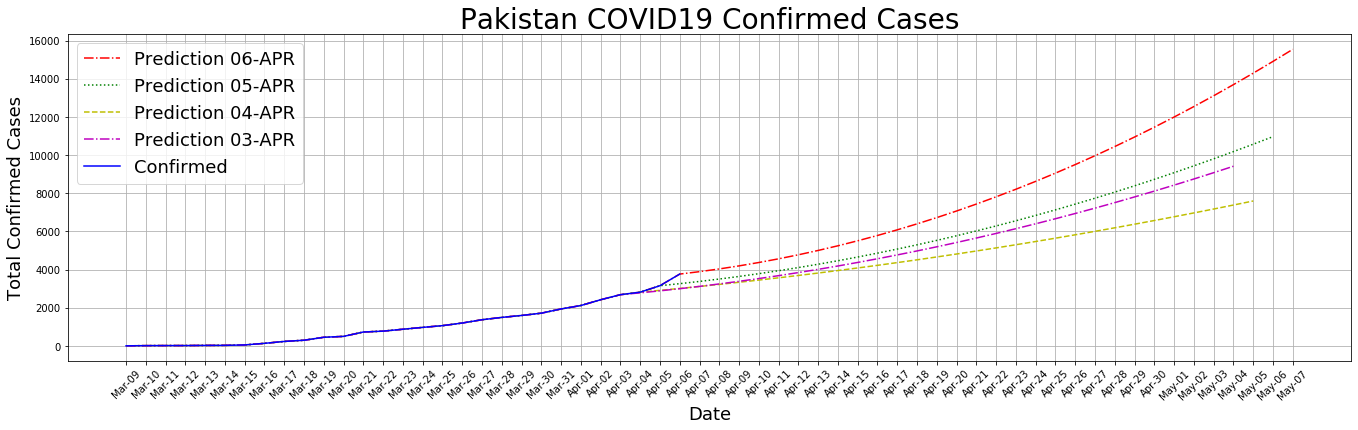

In [17]:
plt.figure(figsize=(23,6))
plt.xticks(rotation = 45)

Date_list = date_format(Date_list)

cc_03 = list(Pakistan_data_new.ConfirmedCases[start_cut:-3].copy())
cc_03.extend(pc_03[:-2])
cc_04 = list(Pakistan_data_new.ConfirmedCases[start_cut:-2].copy())
cc_04.extend(pc_04[:-2])
cc_05 = list(Pakistan_data_new.ConfirmedCases[start_cut:-1].copy())
cc_05.extend(pc_05[:-2])
cc_06 = list(Pakistan_data_new.ConfirmedCases[start_cut:].copy())
cc_06.extend(pc_06[:-2])
cc = Pakistan_data_new.ConfirmedCases[start_cut:].reset_index().drop('index',axis=1)

plt.plot(Date_list,cc_06,'r',linestyle='-.',label='Prediction 06-APR')
plt.plot(Date_list[:-1],cc_05,'g',linestyle=':',label='Prediction 05-APR')
plt.plot(Date_list[:-2],cc_04,'y',linestyle='dashed',label='Prediction 04-APR')
plt.plot(Date_list[:-3],cc_03,'m',linestyle='-.',label='Prediction 03-APR')
plt.plot(cc,'b',label='Confirmed')

plt.xlabel("Date",fontdict={'fontsize': 18})
plt.ylabel("Total Confirmed Cases",fontdict={'fontsize': 18})
plt.legend(fontsize= 18)
plt.title('Pakistan COVID19 Confirmed Cases',fontdict={'fontsize': 28})

plt.grid()
plt.show()

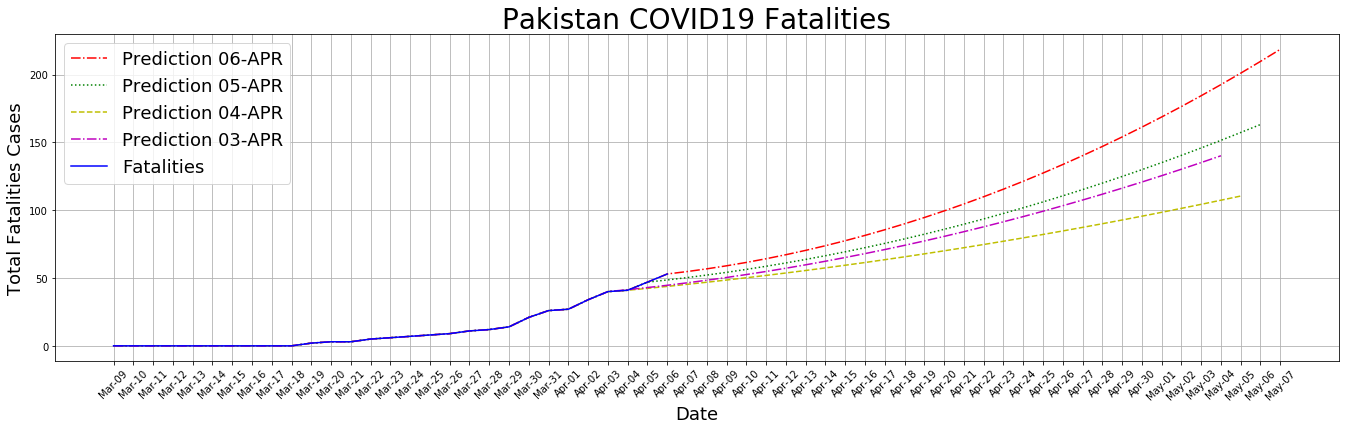

In [18]:
plt.figure(figsize=(23,6))
plt.xticks(rotation = 45)

cf_03 = list(Pakistan_data_new.Fatalities[start_cut:-3].copy())
cf_03.extend(pf_03[:-2])
cf_04 = list(Pakistan_data_new.Fatalities[start_cut:-2].copy())
cf_04.extend(pf_04[:-2])
cf_05 = list(Pakistan_data_new.Fatalities[start_cut:-1].copy())
cf_05.extend(pf_05[:-2])
cf_06 = list(Pakistan_data_new.Fatalities[start_cut:].copy())
cf_06.extend(pf_06[:-2])
cf = Pakistan_data_new.Fatalities[start_cut:].reset_index().drop('index',axis=1)

plt.plot(Date_list,cf_06,'r',linestyle='-.',label='Prediction 06-APR')
plt.plot(Date_list[:-1],cf_05,'g',linestyle=':',label='Prediction 05-APR')
plt.plot(Date_list[:-2],cf_04,'y',linestyle='dashed',label='Prediction 04-APR')
plt.plot(Date_list[:-3],cf_03,'m',linestyle='-.',label='Prediction 03-APR')
plt.plot(cf,'b',label='Fatalities')

plt.xlabel("Date",fontdict={'fontsize': 18})
plt.ylabel("Total Fatalities Cases",fontdict={'fontsize': 18})
plt.legend(fontsize= 18)
plt.title('Pakistan COVID19 Fatalities',fontdict={'fontsize': 28})

plt.grid()
plt.show()